# Neural Networks applied in a radiology 

Author:

Ahumada Lozano Santiago

Here we are supposed to present present the comands coded to train a neural network algorithm in order classify a dataset of X-Ray-Chest images, previously classified according with its diagnosted pathology. 

## Libraries

In [1]:
using Flux, Images, MLDatasets, Plots
using Flux: crossentropy, onecold, onehotbatch, train!
using LinearAlgebra, Random, Statistics
using Images
using TestImages
using ImageIO
using CSV
using DataFrames

In [116]:
using ImageShow
using MosaicViews

## Importing Dataset

The database is a portion of an open medical imaging dataset, this can be viewed from https://www.v7labs.com/open-datasets/chestx-ray14.

In [3]:
url = "C:\\Users\\santi\\OneDrive\\Escritorio\\Matematicas VII\\Numerico\\ProyectoFinal\\BasedeDatos\\images_01\\images"
cd(url)
base_path = pwd()
names_ = readdir(base_path)[1:4998]
size = length(names_)
images = [load(names_[k]) for k in 1:size]; #Here we saved the images information


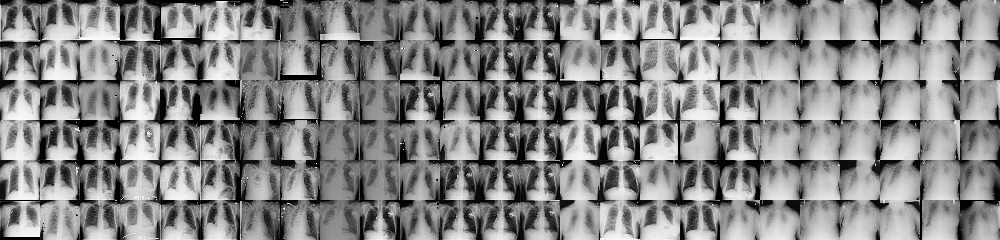

In [141]:
mosaicview(resized_images[1:150], nrow=6)

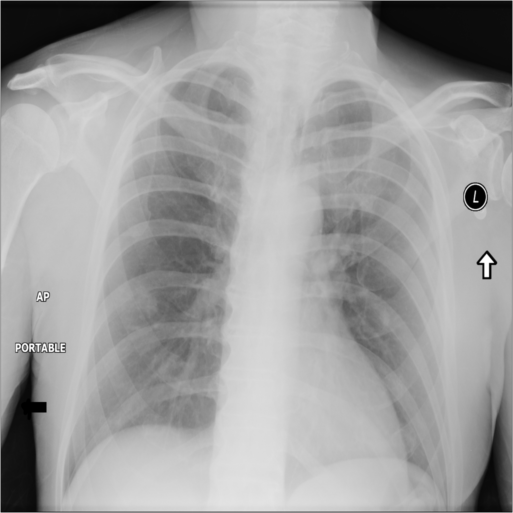

In [4]:
test_image = images[12]

## Dataset treatment

At first, we have done an image processing and filtering in oder to give better parameters to the model. So we did a resizing (from 1024x1024 to 40x40), a gray-scale filtering (since some images -71- were processed by Julia as RGB images) in orden to convert these images to ``` Float64``` Matrices by an easier way.

We attempted also apply a convolutional filter, namely, a Laplacian Kernel (```Kernel.Laplacian()```) and we got nice results for some images, but infortunately we couldn't pass this filter to the whole 4998 images (The Jupyter Kernel crashed).

In [5]:
resized_images = [imresize(images[k], (40,40)) for k in 1:size];

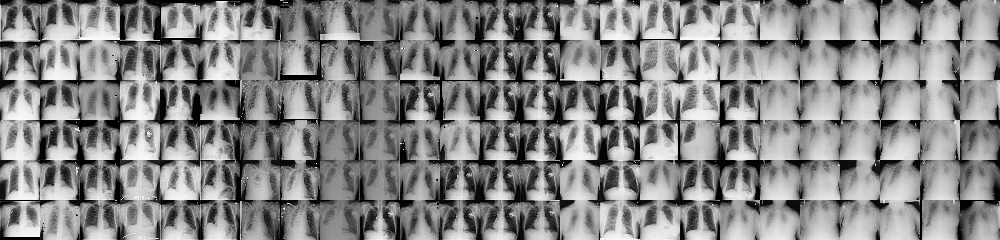

In [6]:
mosaic(resized_images[1:150],nrow=6)

We apply a convolution filter:

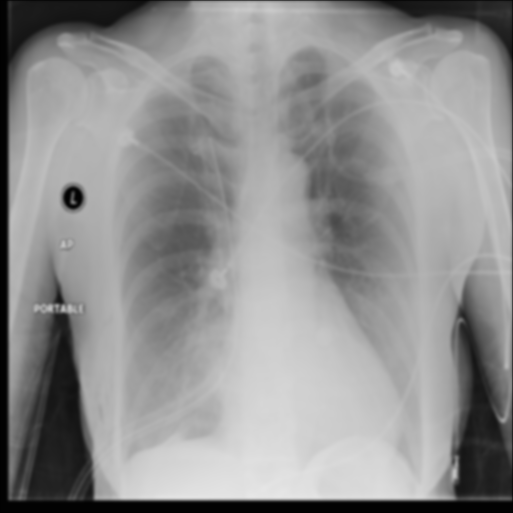

In [7]:
convolved_image = imfilter(images[200], Kernel.gaussian(3))

In [8]:
floated_images = [Float64.(Gray.(resized_images[k])) for k in 1:size]; #FINALLY!!!!

Here we imported the dataset with the correct pathology-classification. But also we imported a dataset with a numerical value associated with each image-name instead of its pathology name 

In [9]:
df = DataFrame(CSV.File("C:\\Users\\santi\\OneDrive\\Escritorio\\Matematicas VII\\Numerico\\ProyectoFinal\\BasedeDatos\\Data_Entry_2017_v2020.csv"));

┌ Warning: thread = 1 warning: only found 9 / 11 columns around data row: 16916. Filling remaining columns with `missing`
└ @ CSV C:\Users\santi\.julia\packages\CSV\jFiCn\src\file.jl:578


In [10]:
database = DataFrame(CSV.File("C:\\Users\\santi\\OneDrive\\Escritorio\\Matematicas VII\\Numerico\\ProyectoFinal\\BasedeDatos\\clasificacion_depured.csv"))

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender
,String31,Int64,Int64,Int64,Int64,String1
1,00000001_000.png,2,0,1,57,M
2,00000001_001.png,11,1,1,58,M
3,00000001_002.png,3,2,1,58,M
4,00000002_000.png,0,0,2,80,M
5,00000003_001.png,14,0,3,74,F
6,00000003_002.png,14,1,3,75,F
7,00000003_003.png,4,2,3,76,F
8,00000003_004.png,14,3,3,77,F
9,00000003_005.png,14,4,3,78,F


In [11]:
names = database[!,1][1:4998]
labels = database[!,2][1:4998]

4998-element Vector{Int64}:
  2
 11
  3
  0
 14
 14
  4
 14
 14
 14
 14
 14
  5
  ⋮
  6
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0

In the following rows you can view how we prepare a raw dataset.

In [12]:
model_images = floated_images;

In [13]:
A = fill(0.0, 40, 40, 4998);  #This matrix is supposed to be used to convert model_images to an Array{Float64,3}

In [14]:
for imag in 1:size
    current_image = model_images[imag]
    for col in 1:40 
        for row in 1:40
            A[row, col, imag] = current_image[row, col]
        end
    end
end

In [15]:
model_images_in_array_form = A;

## Breaking the dataset up

In [89]:
X_train_raw, y_train_raw = model_images_in_array_form[:,:,1:4000], labels[1:4000];
X_test_raw, y_test_raw = model_images_in_array_form[:,:,4001:4998], labels[4001:4998];

In [90]:
X_train = Flux.flatten(X_train_raw);
X_test = Flux.flatten(X_test_raw);

In [91]:
#onehotbatch encode label 

y_train = onehotbatch(y_train_raw, 0:14)
y_test = onehotbatch(y_test_raw, 0:14)

15×998 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  1  1  ⋅  ⋅  …  ⋅  1  1  1  1  1  1  1  1  1  1  1
 ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅

## Building the model

We coded a deep neural network with three layers

1. The first, with $40\times40$ nodes.
2. The intermediate one, with 32 nodes and the activation function ReLu.
3.The last one associated with the 15 possible labels. 

In [99]:
model  = Chain(
    Dense(40*40, 32, relu),
    Dense(32, 15),
    softmax 
)

Chain(
  Dense(1600 => 32, relu),              # 51_232 parameters
  Dense(32 => 15),                      # 495 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 51_727 parameters, 202.309 KiB.

In [100]:
#define loss function

loss(x, y) = crossentropy(model(x), y)

loss (generic function with 1 method)

In [101]:
#track parameters

ps = Flux.params(model);
ps

Params([Float32[0.035802804 -0.010441489 … -0.04623616 -0.056567326; -0.034176093 -0.0115688015 … -0.057169132 0.0041599954; … ; 0.028633963 0.028057534 … -0.002290094 0.012114069; -0.04161583 -0.01760748 … -0.039698914 0.05238024], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.33285654 -0.35007024 … -0.11241559 -0.11102689; 0.26081127 -0.09175822 … 0.11426582 -0.09588777; … ; 0.20168485 -0.32874134 … 0.11847877 -0.15249372; 0.029125892 -0.12517044 … 0.19731572 -0.025792701], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [102]:
#select optimizer

learning_rate = 0.01

opt = ADAM(learning_rate)

ADAM(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

## Training the model

We trained pur neural network model with a total of $1000$ epochs, a learning rate of $0.05$ and we chosen the optimizer ```ADAM```.

In [104]:
#train model

loss_history = []

epochs = 1000

for epoch in 1:epochs
    #train model 
    train!(loss, ps, [(X_train, y_train)], opt)
    #print report
    train_loss = loss(X_train, y_train)
    push!(loss_history, train_loss)
    println("Epoch = $epoch : Training Loss = $train_loss")
end

Epoch = 1 : Training Loss = 1.7387880755936103
Epoch = 2 : Training Loss = 1.7408975676599499
Epoch = 3 : Training Loss = 1.7381098720058725
Epoch = 4 : Training Loss = 1.7370849853406984
Epoch = 5 : Training Loss = 1.7387913103621992
Epoch = 6 : Training Loss = 1.7366176599628071
Epoch = 7 : Training Loss = 1.73579576235339
Epoch = 8 : Training Loss = 1.7369257352981473
Epoch = 9 : Training Loss = 1.735229062878666
Epoch = 10 : Training Loss = 1.7345369632577619
Epoch = 11 : Training Loss = 1.7352960720500155
Epoch = 12 : Training Loss = 1.7338343129017388
Epoch = 13 : Training Loss = 1.733445480820083
Epoch = 14 : Training Loss = 1.7338214163606964
Epoch = 15 : Training Loss = 1.732592630182069
Epoch = 16 : Training Loss = 1.7323718947013538
Epoch = 17 : Training Loss = 1.7324625546861452
Epoch = 18 : Training Loss = 1.7314059212503048
Epoch = 19 : Training Loss = 1.7313473012677492
Epoch = 20 : Training Loss = 1.7311598136265507
Epoch = 21 : Training Loss = 1.730312576039947
Epoch =

Epoch = 214 : Training Loss = 1.6967758029965272
Epoch = 215 : Training Loss = 1.6965987838185406
Epoch = 216 : Training Loss = 1.6964215064328143
Epoch = 217 : Training Loss = 1.6962439715189819
Epoch = 218 : Training Loss = 1.6960661778446209
Epoch = 219 : Training Loss = 1.6958881258442202
Epoch = 220 : Training Loss = 1.6957098162754245
Epoch = 221 : Training Loss = 1.6955312475337239
Epoch = 222 : Training Loss = 1.6953524211622157
Epoch = 223 : Training Loss = 1.6951733362791772
Epoch = 224 : Training Loss = 1.6949939914877976
Epoch = 225 : Training Loss = 1.6948143884695723
Epoch = 226 : Training Loss = 1.6946345270300427
Epoch = 227 : Training Loss = 1.6944544074871755
Epoch = 228 : Training Loss = 1.6942740293251606
Epoch = 229 : Training Loss = 1.694093392981777
Epoch = 230 : Training Loss = 1.6939125928069156
Epoch = 231 : Training Loss = 1.6937317637161058
Epoch = 232 : Training Loss = 1.69355070447157
Epoch = 233 : Training Loss = 1.6933693998830974
Epoch = 234 : Training 

Epoch = 424 : Training Loss = 1.6682522749852315
Epoch = 425 : Training Loss = 1.6682949647737912
Epoch = 426 : Training Loss = 1.6682365712015954
Epoch = 427 : Training Loss = 1.6682581195578927
Epoch = 428 : Training Loss = 1.6682119639230109
Epoch = 429 : Training Loss = 1.6683678515607618
Epoch = 430 : Training Loss = 1.668511697424613
Epoch = 431 : Training Loss = 1.6690891339773415
Epoch = 432 : Training Loss = 1.669737362953506
Epoch = 433 : Training Loss = 1.6716312319485036
Epoch = 434 : Training Loss = 1.6735927971879196
Epoch = 435 : Training Loss = 1.6791733213783941
Epoch = 436 : Training Loss = 1.6828059238831783
Epoch = 437 : Training Loss = 1.6949869578871077
Epoch = 438 : Training Loss = 1.6922929148245884
Epoch = 439 : Training Loss = 1.6968819576397514
Epoch = 440 : Training Loss = 1.680238570891369
Epoch = 441 : Training Loss = 1.6705209849314937
Epoch = 442 : Training Loss = 1.6653991268508879
Epoch = 443 : Training Loss = 1.667798632687586
Epoch = 444 : Training L

Epoch = 634 : Training Loss = 1.6547324239766754
Epoch = 635 : Training Loss = 1.6636204397716188
Epoch = 636 : Training Loss = 1.6552891147306432
Epoch = 637 : Training Loss = 1.6480692877822003
Epoch = 638 : Training Loss = 1.6465528083191847
Epoch = 639 : Training Loss = 1.6511588504920183
Epoch = 640 : Training Loss = 1.6568084348043777
Epoch = 641 : Training Loss = 1.6527082927951477
Epoch = 642 : Training Loss = 1.6481256753300058
Epoch = 643 : Training Loss = 1.645681956037847
Epoch = 644 : Training Loss = 1.647564798479761
Epoch = 645 : Training Loss = 1.6512007014568544
Epoch = 646 : Training Loss = 1.6507909166227477
Epoch = 647 : Training Loss = 1.6490917541992482
Epoch = 648 : Training Loss = 1.6460700120969423
Epoch = 649 : Training Loss = 1.6451390625710314
Epoch = 650 : Training Loss = 1.6463864637471393
Epoch = 651 : Training Loss = 1.648095150266472
Epoch = 652 : Training Loss = 1.6494598568619694
Epoch = 653 : Training Loss = 1.6481354724012278
Epoch = 654 : Training 

Epoch = 845 : Training Loss = 1.6352992098245895
Epoch = 846 : Training Loss = 1.6406170860133171
Epoch = 847 : Training Loss = 1.6426719188037668
Epoch = 848 : Training Loss = 1.6468090439830403
Epoch = 849 : Training Loss = 1.6431654040715593
Epoch = 850 : Training Loss = 1.6421041725126069
Epoch = 851 : Training Loss = 1.636985809629508
Epoch = 852 : Training Loss = 1.6340713628116037
Epoch = 853 : Training Loss = 1.631495165179432
Epoch = 854 : Training Loss = 1.6302784757402708
Epoch = 855 : Training Loss = 1.629599889606646
Epoch = 856 : Training Loss = 1.629276366816673
Epoch = 857 : Training Loss = 1.6291103997843468
Epoch = 858 : Training Loss = 1.6290728435274904
Epoch = 859 : Training Loss = 1.6291642992246413
Epoch = 860 : Training Loss = 1.6294001470506339
Epoch = 861 : Training Loss = 1.6301211865209628
Epoch = 862 : Training Loss = 1.6313991584006635
Epoch = 863 : Training Loss = 1.634523470555272
Epoch = 864 : Training Loss = 1.6388278660410978
Epoch = 865 : Training Lo

In [105]:
y_hat_raw = model(X_test)
y_hat = onecold(y_hat_raw) .-1
y = y_test_raw #labelled data
mean(y_hat .== y)

0.5681362725450901

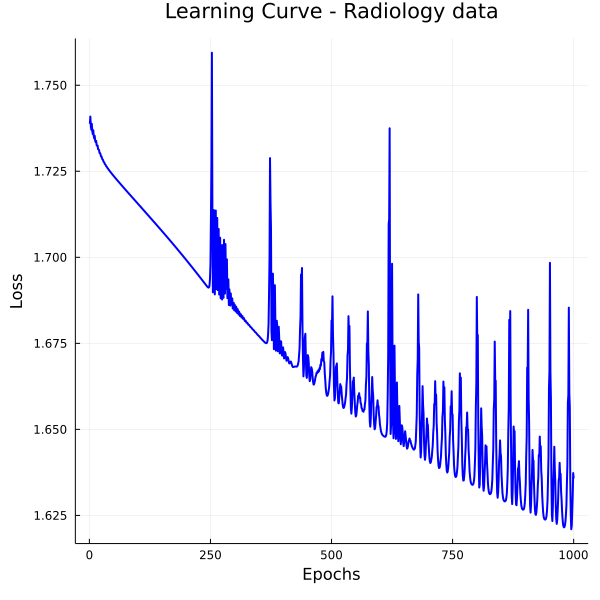

In [113]:
#plot loss
gr(size = (600,600))
#plot learning curve
p_l_curve = plot(1:epochs, loss_history,
    xlabel = "Epochs",
    ylabel = "Loss",
    title = "Learning Curve - Radiology data",
    legend = false,
    color  = :blue,
    linewidth = 2
)

#Notice that this plot doesn´t correspond exactly with the one reported previously. It is due of a change of the ADAM initial parameter. 


Finally, we have gotten a loss of $1.635$ from the model and we could clasify a $\%56.8$ with success.